<a href="https://colab.research.google.com/github/khanhvietdm-glitch/BTC-Trading/blob/main/TRADING_BTC_BASED_ON_DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install stable_baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 12.5 MB/s eta 0:00:00


In [2]:
# Lấy mô hình đã chạy để chạy mới
#!/usr/bin/env python3
# apply_saved_policy.py
# Yêu cầu: torch, pandas, numpy, scikit-learn, gym, stable-baselines3

import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import gym
from gym import spaces
from stable_baselines3 import DQN

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=

In [3]:
pip install 'shimmy>=2.0'

In [10]:
# Lấy mô hình đã chạy để chạy mới
#!/usr/bin/env python3
# apply_saved_policy_with_signal.py
# Yêu cầu: torch, pandas, numpy, scikit-learn, gym, stable-baselines3

import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import gym
from gym import spaces
from stable_baselines3 import DQN

# --- 1. Tính chỉ báo như lúc train ---
def add_technical(df):
    df = df.copy()
    df['log_ret'] = np.log(df['close']).diff()
    delta = df['close'].diff()
    gain  = delta.clip(lower=0).rolling(14).mean()
    loss  = (-delta.clip(upper=0)).rolling(14).mean().replace(0,1e-6)
    df['rsi']    = 100 - 100/(1 + gain/loss)
    df['sma_5']  = df['close'].rolling(5).mean()
    df['sma_10'] = df['close'].rolling(10).mean()
    mb   = df['close'].rolling(20).mean()
    sig  = df['close'].rolling(20).std()
    df['boll_up'] = mb + 2*sig
    df['boll_lb'] = mb - 2*sig
    return df.dropna()

# Đọc toàn bộ file, split train/test
xls      = pd.ExcelFile('/content/btc_daily_data 14-06.xlsx')
full_df  = pd.read_excel(xls, 'BTC_Daily', parse_dates=['time']).set_index('time').sort_index()
full_df  = add_technical(full_df)

split_date = '2022-1-1'
train_df   = full_df[:split_date]
test_df    = full_df[split_date:]

# --- 2. Scale & PCA ---
features   = ['log_ret','rsi','sma_5','sma_10','boll_up','boll_lb','volume']
scaler     = MinMaxScaler()
train_vals = scaler.fit_transform(train_df[features])
test_vals  = scaler.transform(test_df[features])

pca        = PCA(n_components=5)
train_pca  = pca.fit_transform(train_vals)
test_pca   = pca.transform(test_vals)

# --- 3. Định nghĩa môi trường FSRL ---
class FSRLEnv(gym.Env):
    def __init__(self, df, pca_arr, window=20, cash_start=1e6):
        super().__init__()
        self.df           = df.reset_index(drop=True)
        self.times_index  = df.index
        self.pca_arr      = pca_arr
        self.window       = window
        self.cash_start   = cash_start
        self.action_space = spaces.Discrete(5)
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf,
            shape=(window * pca_arr.shape[1],),
            dtype=np.float32
        )
        self.reset()

    def reset(self):
        self.t        = self.window
        self.cash     = self.cash_start
        self.nav      = [self.cash]
        self.times    = []
        self.signals  = []
        return self._get_state()

    def _get_state(self):
        return self.pca_arr[self.t-self.window:self.t].flatten()

    def step(self, action):
        action = int(action)
        row    = self.df.iloc[self.t]

        # chọn signal
        if   action == 0:
            signal = 1 if row.rsi < 30 else (-1 if row.rsi > 70 else 0)
        elif action == 1:
            signal = 1 if row.sma_5 > row.sma_10 else (-1 if row.sma_5 < row.sma_10 else 0)
        elif action == 2:
            signal = 1 if row.close < row.boll_lb else (-1 if row.close > row.boll_up else 0)
        elif action == 3:
            mom    = (row.close / self.df.close.iloc[self.t-20]) - 1
            signal = 1 if mom > 0 else -1
        else:
            prices = self.df.close.iloc[self.t-20:self.t]
            vols   = self.df.volume.iloc[self.t-20:self.t]
            vwap   = (prices * vols).sum() / vols.sum()
            signal = 1 if row.close < vwap else -1

        # cập nhật NAV
        ret = signal * row.log_ret
        self.cash *= np.exp(ret)
        self.nav.append(self.cash)

        # lưu lịch sử
        self.signals.append(signal)
        self.times.append(self.times_index[self.t])

        self.t += 1
        done = self.t >= len(self.df)
        return self._get_state(), ret, done, {}

# --- 4. Tạo env_test và load model đã train ---
env_test = FSRLEnv(test_df, test_pca)
model    = DQN.load("/content/fsrl_crypto_model.zip", env=env_test)

# --- 5. Inference trên tập test ---
obs     = env_test.reset()
done    = False
actions = []
signals = []
navs    = []
times   = []

while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, _, done, _ = env_test.step(action)

    actions.append(int(action))
    signals.append(env_test.signals[-1])
    navs.append(env_test.nav[-1])
    times.append(env_test.times[-1])

# --- 6. Xuất kết quả ra Excel ---
strategy_map = {
    0: 'RSI-Strategy',
    1: 'SMA-Crossover',
    2: 'Bollinger-Reversion',
    3: 'Momentum-20d',
    4: 'VWAP-Reversion'
}

df_out = pd.DataFrame({
    'time':     times,
    'action':   actions,
    'signal':   signals,
    'strategy': [strategy_map[a] for a in actions],
    'nav':      navs
})
df_out.to_excel('BTC 14-6.xlsx', index=False)

/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


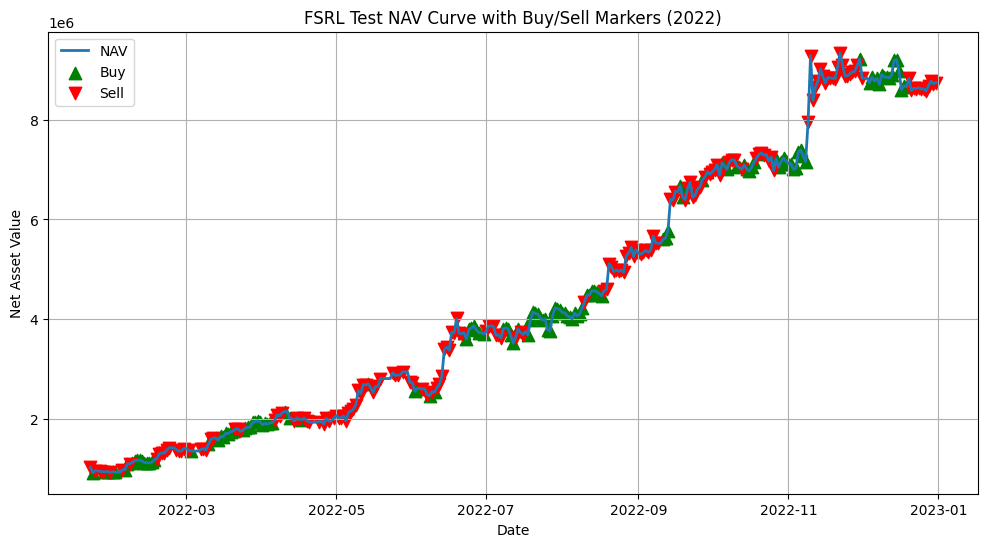

In [11]:
# 7. Vẽ NAV Curve + Buy/Sell markers
# =========================
import matplotlib.pyplot as plt
import pandas as pd

# Create a DataFrame named 'trades' from 'df_out'
trades = df_out.copy()

# Filter data for the year 2022
trades_2022 = trades[trades['time'].dt.year == 2022]
nav_times_2022 = [t for t in times if pd.to_datetime(t).year == 2022]
nav_vals_2022 = [navs[i] for i in range(len(times)) if pd.to_datetime(times[i]).year == 2022]

buy_times_2022 = trades_2022['time'][trades_2022['signal'] == 1].tolist()
buy_vals_2022 = trades_2022['nav'][trades_2022['signal'] == 1].tolist()
sell_times_2022 = trades_2022['time'][trades_2022['signal'] == -1].tolist()
sell_vals_2022 = trades_2022['nav'][trades_2022['signal'] == -1].tolist()

plt.figure(figsize=(12,6))
plt.plot(nav_times_2022, nav_vals_2022, label='NAV', linewidth=2)
plt.scatter(buy_times_2022, buy_vals_2022, marker='^', color='green',  s=80, label='Buy')
plt.scatter(sell_times_2022, sell_vals_2022, marker='v', color='red',    s=80, label='Sell')
plt.title('FSRL Test NAV Curve with Buy/Sell Markers (2022)')
plt.xlabel('Date')
plt.ylabel('Net Asset Value')
plt.legend()
plt.grid(True)
plt.show()

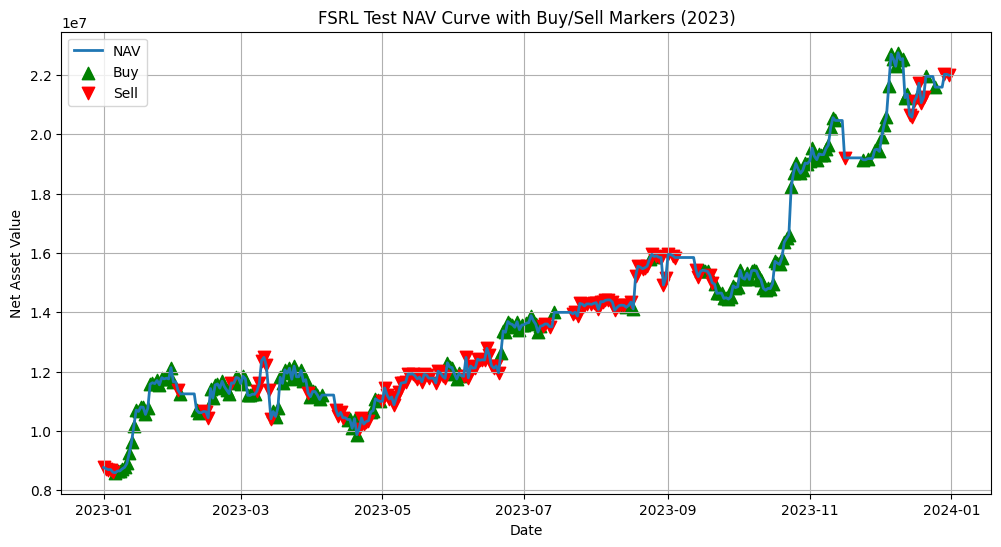

In [12]:
# 7. Vẽ NAV Curve + Buy/Sell markers
# =========================
import matplotlib.pyplot as plt
import pandas as pd

# Create a DataFrame named 'trades' from 'df_out'
trades = df_out.copy()

# Filter data for the year 2023
trades_2023 = trades[trades['time'].dt.year == 2023]
nav_times_2023 = [t for t in times if pd.to_datetime(t).year == 2023]
nav_vals_2023 = [navs[i] for i in range(len(times)) if pd.to_datetime(times[i]).year == 2023]

buy_times_2023 = trades_2023['time'][trades_2023['signal'] == 1].tolist()
buy_vals_2023 = trades_2023['nav'][trades_2023['signal'] == 1].tolist()
sell_times_2023 = trades_2023['time'][trades_2023['signal'] == -1].tolist()
sell_vals_2023 = trades_2023['nav'][trades_2023['signal'] == -1].tolist()

plt.figure(figsize=(12,6))
plt.plot(nav_times_2023, nav_vals_2023, label='NAV', linewidth=2)
plt.scatter(buy_times_2023, buy_vals_2023, marker='^', color='green',  s=80, label='Buy')
plt.scatter(sell_times_2023, sell_vals_2023, marker='v', color='red',    s=80, label='Sell')
plt.title('FSRL Test NAV Curve with Buy/Sell Markers (2023)')
plt.xlabel('Date')
plt.ylabel('Net Asset Value')
plt.legend()
plt.grid(True)
plt.show()

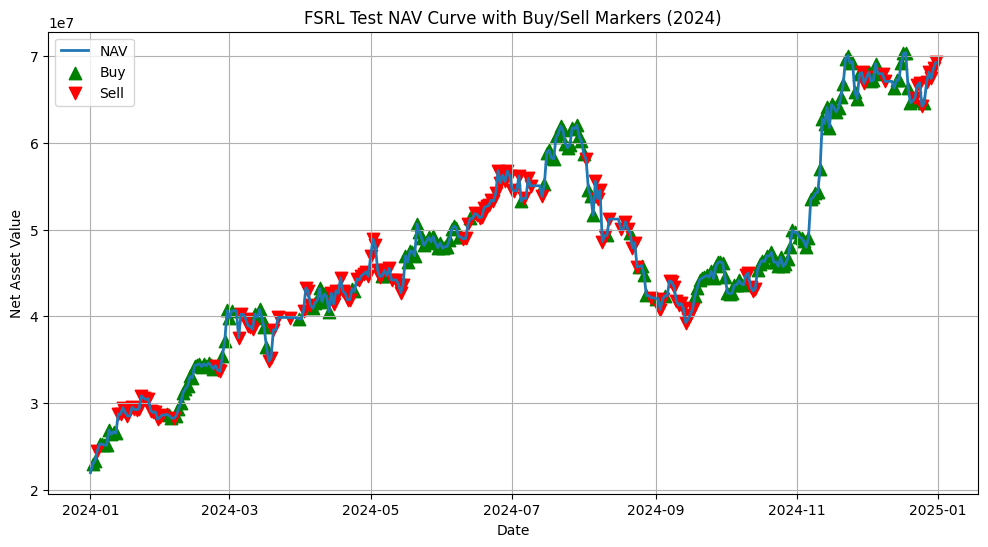

In [13]:
# 7. Vẽ NAV Curve + Buy/Sell markers
# =========================
import matplotlib.pyplot as plt
import pandas as pd

# Create a DataFrame named 'trades' from 'df_out'
trades = df_out.copy()

# Filter data for the year 2024
trades_2024 = trades[trades['time'].dt.year == 2024]
nav_times_2024 = [t for t in times if pd.to_datetime(t).year == 2024]
nav_vals_2024 = [navs[i] for i in range(len(times)) if pd.to_datetime(times[i]).year == 2024]

buy_times_2024 = trades_2024['time'][trades_2024['signal'] == 1].tolist()
buy_vals_2024 = trades_2024['nav'][trades_2024['signal'] == 1].tolist()
sell_times_2024 = trades_2024['time'][trades_2024['signal'] == -1].tolist()
sell_vals_2024 = trades_2024['nav'][trades_2024['signal'] == -1].tolist()

plt.figure(figsize=(12,6))
plt.plot(nav_times_2024, nav_vals_2024, label='NAV', linewidth=2)
plt.scatter(buy_times_2024, buy_vals_2024, marker='^', color='green',  s=80, label='Buy')
plt.scatter(sell_times_2024, sell_vals_2024, marker='v', color='red',    s=80, label='Sell')
plt.title('FSRL Test NAV Curve with Buy/Sell Markers (2024)')
plt.xlabel('Date')
plt.ylabel('Net Asset Value')
plt.legend()
plt.grid(True)
plt.show()

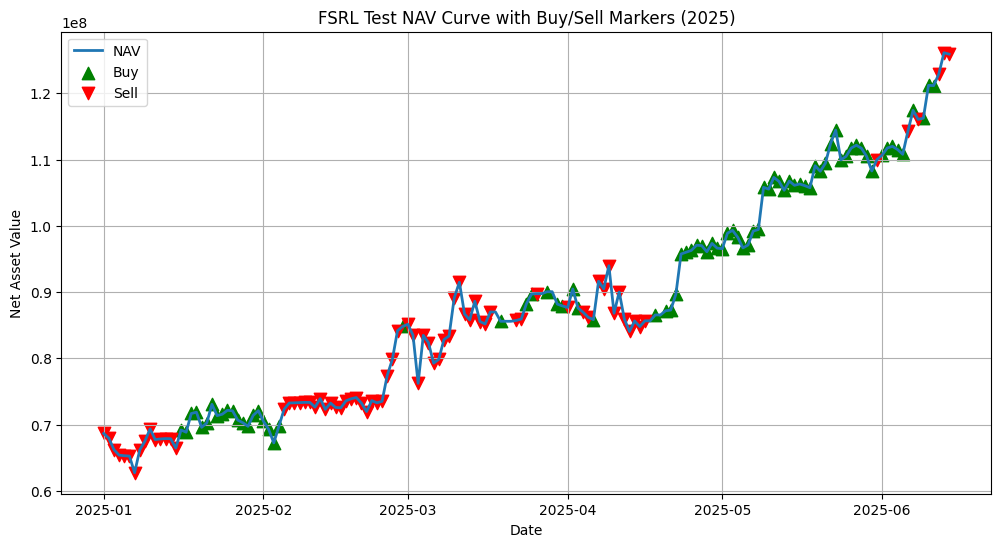

In [14]:
# 7. Vẽ NAV Curve + Buy/Sell markers
# =========================
import matplotlib.pyplot as plt
import pandas as pd

# Create a DataFrame named 'trades' from 'df_out'
trades = df_out.copy()

# Filter data for the year 2025
trades_2025 = trades[trades['time'].dt.year == 2025]
nav_times_2025 = [t for t in times if pd.to_datetime(t).year == 2025]
nav_vals_2025 = [navs[i] for i in range(len(times)) if pd.to_datetime(times[i]).year == 2025]

buy_times_2025 = trades_2025['time'][trades_2025['signal'] == 1].tolist()
buy_vals_2025 = trades_2025['nav'][trades_2025['signal'] == 1].tolist()
sell_times_2025 = trades_2025['time'][trades_2025['signal'] == -1].tolist()
sell_vals_2025 = trades_2025['nav'][trades_2025['signal'] == -1].tolist()

plt.figure(figsize=(12,6))
plt.plot(nav_times_2025, nav_vals_2025, label='NAV', linewidth=2)
plt.scatter(buy_times_2025, buy_vals_2025, marker='^', color='green',  s=80, label='Buy')
plt.scatter(sell_times_2025, sell_vals_2025, marker='v', color='red',    s=80, label='Sell')
plt.title('FSRL Test NAV Curve with Buy/Sell Markers (2025)')
plt.xlabel('Date')
plt.ylabel('Net Asset Value')
plt.legend()
plt.grid(True)
plt.show()

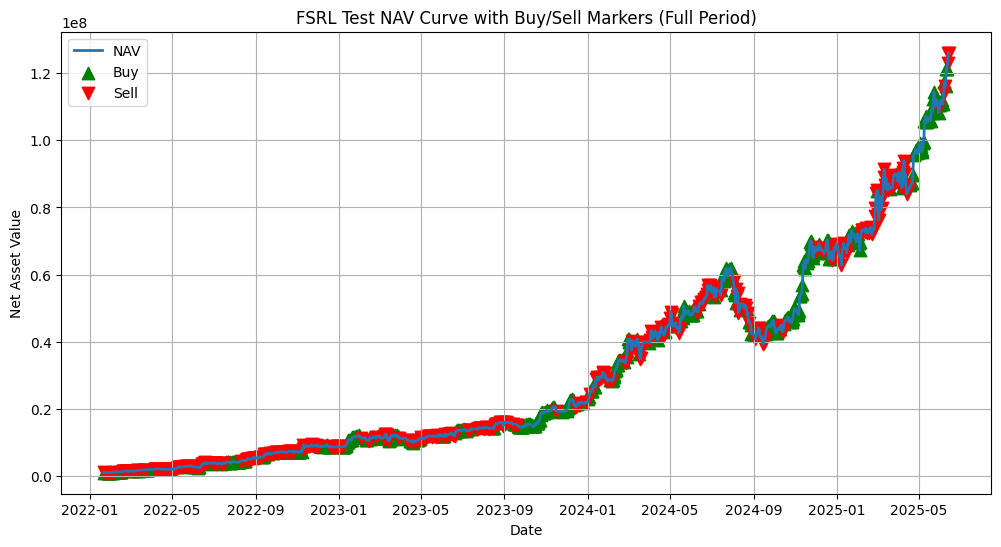

In [15]:
# 7. Vẽ NAV Curve + Buy/Sell markers
# =========================
import matplotlib.pyplot as plt
import pandas as pd

# Create a DataFrame named 'trades' from 'df_out'
trades = df_out.copy()

# Use all data, no year filtering
nav_times_all = [t for t in times]
nav_vals_all = [navs[i] for i in range(len(times))]

buy_times_all = trades['time'][trades['signal'] == 1].tolist()
buy_vals_all = trades['nav'][trades['signal'] == 1].tolist()
sell_times_all = trades['time'][trades['signal'] == -1].tolist()
sell_vals_all = trades['nav'][trades['signal'] == -1].tolist()

plt.figure(figsize=(12,6))
plt.plot(nav_times_all, nav_vals_all, label='NAV', linewidth=2)
plt.scatter(buy_times_all, buy_vals_all, marker='^', color='green',  s=80, label='Buy')
plt.scatter(sell_times_all, sell_vals_all, marker='v', color='red',    s=80, label='Sell')
plt.title('FSRL Test NAV Curve with Buy/Sell Markers (Full Period)')
plt.xlabel('Date')
plt.ylabel('Net Asset Value')
plt.legend()
plt.grid(True)
plt.show()